In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import requests
from io import StringIO

from sklearn.cluster import KMeans

from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.geocoding import reverse_geocode

from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram
import numpy.matlib
from sklearn.metrics import silhouette_score

from collections import Counter

import os
import sys

# 1. Cluster Analysis

In [7]:
# load master dataframe

df_m = pd.read_csv(os.path.join(sys.path[0], 'Masterdf_crime.csv'))

df_m.head()

,Unnamed: 0,event_unique_id,occurrencedate,reporteddate,premisetype,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,...,Not_in_workforce,Resident_with_Credentials,Resident_without_credentials,15_to_24_WithCred,25_to_65_WithCred,Average Household Income,TTL_RES_UNIT,Soc_Units,RGI,CRCNumLocations
0,0,GO-20141756319,2014-03-24 00:00:00+00:00,2014-03-24 00:00:00+00:00,Commercial,Assault,2014.0,March,24.0,83.0,...,13610,74850,10835,34640,40210,29573,1,1014,630,3.0
1,1,GO-20143006885,2014-09-27 00:00:00+00:00,2014-09-29 00:00:00+00:00,Other,B&E,2014.0,September,27.0,270.0,...,8950,74030,985,34495,39535,56526,35,754,313,0.0
2,2,GO-20141756802,2014-03-24 00:00:00+00:00,2014-03-24 00:00:00+00:00,Commercial,B&E,2014.0,March,24.0,83.0,...,9995,58300,8455,26860,31440,31771,179,950,411,0.0
3,3,GO-20141760570,2014-03-24 00:00:00+00:00,2014-03-24 00:00:00+00:00,Apartment,B&E,2014.0,March,24.0,83.0,...,8885,61775,3330,27585,34190,37379,10,111,109,1.0
4,4,GO-20142004859,2014-05-03 00:00:00+00:00,2014-05-03 00:00:00+00:00,Commercial,Robbery - Business,2014.0,May,3.0,123.0,...,3110,34110,2380,14120,19990,49709,1,84,48,0.0


In [8]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205321 entries, 0 to 205320
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    205321 non-null  int64  
 1   event_unique_id               205321 non-null  object 
 2   occurrencedate                205321 non-null  object 
 3   reporteddate                  205321 non-null  object 
 4   premisetype                   205321 non-null  object 
 5   offence                       205321 non-null  object 
 6   occurrenceyear                205321 non-null  float64
 7   occurrencemonth               205321 non-null  object 
 8   occurrenceday                 205321 non-null  float64
 9   occurrencedayofyear           205321 non-null  float64
 10  occurrencedayofweek           205321 non-null  object 
 11  occurrencehour                205321 non-null  int64  
 12  MCI                           205321 non-nul

In [9]:
# categorize crimes - given the bulk of data is Assault, this will be useful later 

personal = ['Assault']
property = ['Auto Theft','Break and Enter','Robbery', 'Theft Over']
df_m.loc[(df_m['MCI'] == 'Assault'),'crime_category'] = "Personal"
df_m.loc[(df_m['MCI'] == 'Auto Theft') | (df_m['MCI'] == 'Break and Enter') | (df_m['MCI'] == 'Robbery') | (df_m['MCI'] == 'Theft Over'),'crime_category'] = "Property"
df_m['crime_category'] = df_m['crime_category'].fillna(0)
df_m['crime_category'] = df_m['crime_category'].fillna(0)

### Question: In exploratory, found crime was less when more CRC
<break>

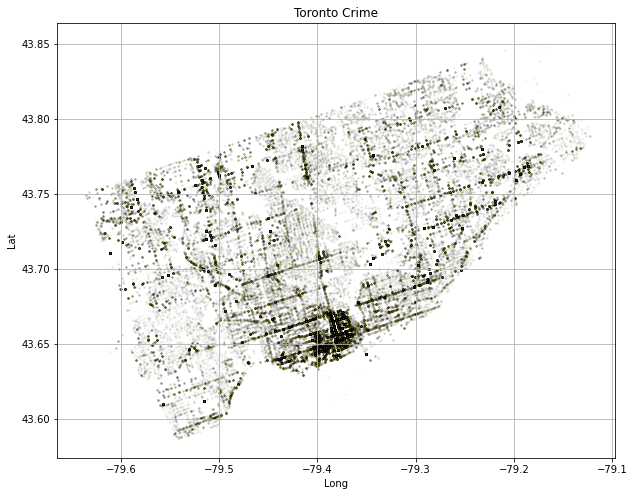

In [10]:
plt.figure(num=None, figsize=(10, 8))
plt.scatter("Long", "Lat", data = df_m, c = 'y',alpha = 0.02, edgecolor = 'black', s=2)
plt.grid()
plt.xlabel('Long')
plt.ylabel('Lat')
plt.title('Toronto Crime')
plt.show()

In [11]:
top_ten = df_m.groupby('Neighbourhood')[['MCI']].count().sort_values(by=['MCI'],ascending=False)

In [12]:
top_ten.head(10)

,MCI
Neighbourhood,
Waterfront Communities-The Island (77),7707
Bay Street Corridor (76),6800
Church-Yonge Corridor (75),6217
West Humber-Clairville (1),5680
Moss Park (73),4768
York University Heights (27),3967
Downsview-Roding-CFB (26),3951
Kensington-Chinatown (78),3812
Woburn (137),3779


In [13]:
# take subset of columns from the dataframe
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205321 entries, 0 to 205320
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    205321 non-null  int64  
 1   event_unique_id               205321 non-null  object 
 2   occurrencedate                205321 non-null  object 
 3   reporteddate                  205321 non-null  object 
 4   premisetype                   205321 non-null  object 
 5   offence                       205321 non-null  object 
 6   occurrenceyear                205321 non-null  float64
 7   occurrencemonth               205321 non-null  object 
 8   occurrenceday                 205321 non-null  float64
 9   occurrencedayofyear           205321 non-null  float64
 10  occurrencedayofweek           205321 non-null  object 
 11  occurrencehour                205321 non-null  int64  
 12  MCI                           205321 non-nul

In [14]:
# make copy of dataframe, drop unnecessary cols
df_m2 = df_m.drop(['Unnamed: 0','event_unique_id','Neighbourhood'], axis=1)

In [15]:
occurrencedate_list = df_m2.occurrencedate.str.split('T').tolist()
reporteddate_list = df_m2.reporteddate.str.split('T').tolist()

for i in range(len(occurrencedate_list)):
    occurrencedate_list[i] = occurrencedate_list[i][0]

for i in range(len(reporteddate_list)):
    reporteddate_list[i] = reporteddate_list[i][0]
    
df_m2['occurrencedate'] = occurrencedate_list
df_m2['reporteddate'] = reporteddate_list

df_m2.occurrencedate = pd.to_datetime(df_m2.occurrencedate)
df_m2.reporteddate = pd.to_datetime(df_m2.reporteddate)

In [16]:
df_m2.drop(['occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear'],axis=1, inplace=True)

In [17]:
# change string variables into type category
df_m2.premisetype = df_m2.premisetype.astype('category', errors='raise')
df_m2.offence = df_m2.offence.astype('category', errors='raise')
df_m2.MCI = df_m2.MCI.astype('category', errors='raise')
df_m2.crime_category = df_m2.crime_category.astype('category', errors='raise')

# there are whitespaces in the days of week, which should be removed before transformation
df_m2.occurrencedayofweek = df_m2.occurrencedayofweek.str.rstrip().astype('category', errors='raise')


In [18]:
def doKMeans(data, n_clusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(data.Long, data.Lat, marker='.', c='blue', alpha=0.01)
    
    data = data.loc[:, ['Long', 'Lat']]
    
    model = KMeans(n_clusters=n_clusters)
    model.fit(data)
    
    centroids = model.cluster_centers_
    print(centroids)
    ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=1, linewidths=3, s=200)
    plt.show()
    
    return model.cluster_centers_, model.labels_

In [19]:
def center():
#    m.center = [43.651070, -79.347015]           # `[latitude, longitude]`
    m.center = [43.6865387,-79.4004602]           # `[latitude, longitude]`
    m.zoom = 11

In [20]:
def plot_crimes():
    layer_crime = gis.content.import_data(df_m2.loc[:,['Long','Lat','MCI','occurrencedate']].head(1000))
    m.add_layer(layer_crime)

In [21]:
# draw centroids

def draw_centroids():
# crime with neighbourhoods with less than 3 community rec centres
    smallcrc = df_m2[(df_m2.CRCNumLocations <= 2)]
    smallcrc.reset_index(inplace=True, drop=True)
    centroid1_less2 = reverse_geocode([-79.2680149  , 43.75278887])
    centroid2_less2 = reverse_geocode([-79.39109485 , 43.67247222])
    centroid3_less2 = reverse_geocode([-79.51720604 , 43.70864408])
    # neighhbourhoods with CRC >2
    largecrc = df_m2[(df_m2.CRCNumLocations > 2)]
    largecrc.reset_index(inplace=True, drop=True)
    centroid1_gr2 = reverse_geocode([-79.51529888,  43.74322173])
    centroid2_gr2 = reverse_geocode([-79.2426951 ,  43.75645189])
    centroid3_gr2 = reverse_geocode([-79.49433183 , 43.63113906])
    pt_sym = {
        "type": "esriSMS",
        "style": "esriSMSDiamond",
        "color": [0,0,255,255],        
        "size": 14,
        "angle": 0,
        "xoffset": 0,
        "yoffset": 0,
        "outline": {
            "color": [0,0,255,255],
            "width": 1}
    }
    pt_sym2 = {
        "type": "esriSMS",
        "style": "esriSMSTriangle",
        "color": [76,115,0,255],        
        "size": 14,
        "angle": 0,
        "xoffset": 0,
        "yoffset": 0,
        "outline": {
            "color": [76,115,0,255],
            "width": 1}
    }
    popup = { 
        "title" : "centroid1_less2", 
        "content" : centroid1_less2['address']
        }
    m.draw(centroid1_less2['location'],symbol=pt_sym)

    popup = { 
        "title" : "centroid2_less2", 
        "content" : centroid2_less2['address']
        }
    m.draw(centroid2_less2['location'],symbol=pt_sym)

    popup = { 
        "title" : "centroid3_less2", 
        "content" : centroid3_less2['address']
        }
    m.draw(centroid3_less2['location'],symbol=pt_sym)

    popup = { 
        "title" : "centroid1_gr2", 
        "content" : centroid1_gr2['address']
        }
    m.draw(centroid1_gr2['location'],symbol=pt_sym2)

    popup = { 
        "title" : "centroid2_gr2", 
        "content" : centroid2_gr2['address']
        }
    m.draw(centroid2_gr2['location'],symbol=pt_sym2)

    popup = { 
        "title" : "centroid3_gr2", 
        "content" : centroid3_gr2['address']
        }
    m.draw(centroid3_gr2['location'],symbol=pt_sym2)

In [22]:
### TPS REST endpoint: https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Neighbourhood_MCI/FeatureServer
tps_id = 'af500b5abb7240399853b35a2362d0c0'
gis = GIS()
tps_item = gis.content.get(tps_id)
tps_item

<Item title:"Neighbourhood Crime Rates (Boundary File) " type:Feature Layer Collection owner:TorontoPoliceService>

In [23]:
m = gis.map()
m.add_layer(tps_item)
m.basemap = "satellite"
m

MapView(layout=Layout(height='400px', width='100%'))

In [24]:
center()

In [25]:
plot_crimes()

In [26]:
draw_centroids()

In [27]:
smallcrc = df_m2[(df_m2.CRCNumLocations <= 2)]
smallcrc.reset_index(inplace=True, drop=True)
centroid1_less2 = reverse_geocode([-79.2680149  , 43.75278887])
centroid2_less2 = reverse_geocode([-79.39109485 , 43.67247222])
centroid3_less2 = reverse_geocode([-79.51720604 , 43.70864408])
# neighhbourhoods with CRC >2
largecrc = df_m2[(df_m2.CRCNumLocations > 2)]
largecrc.reset_index(inplace=True, drop=True)
centroid1_gr2 = reverse_geocode([-79.51529888,  43.74322173])
centroid2_gr2 = reverse_geocode([-79.2426951 ,  43.75645189])
centroid3_gr2 = reverse_geocode([-79.49433183 , 43.63113906])

[[-79.53125141  43.75327673]
 [-79.24232927  43.75624556]
 [-79.48214143  43.65820135]]


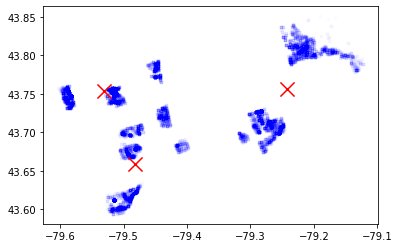

In [28]:
# looking at this , probably better to have at least another centroid for east
centroids, labels = doKMeans(largecrc, 3)

[[-79.39572674  43.67857875]
 [-79.27256438  43.75504327]
 [-79.52914251  43.70476997]]


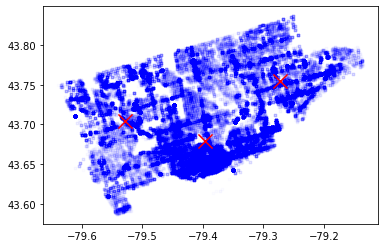

In [29]:
#personal_smallcrc = df_m2[(df_m2.crime_category =='Personal') & (df_m2.CRCNumLocations <= 2)]

smallcrc = df_m2[(df_m2.CRCNumLocations <= 2)]
smallcrc.reset_index(inplace=True, drop=True)

centroids, labels = doKMeans(smallcrc, 3)

[[-79.52929274  43.70497947]
 [-79.39628364  43.6782502 ]
 [-79.27336272  43.75451709]]


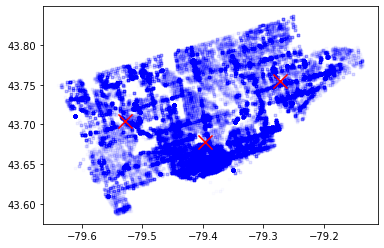

In [30]:
centroids, labels = doKMeans(smallcrc, 3)

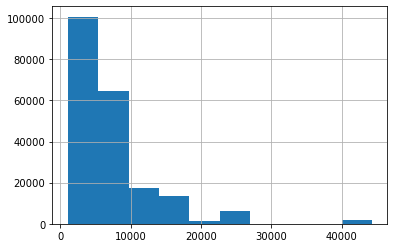

In [31]:
df_m2.PopDen.hist()

In [32]:
df_m2.PopDen.mean()

7069.787162540607

[[-79.38162736  43.72893609]
 [-79.52274479  43.69820881]
 [-79.25219353  43.76180505]]


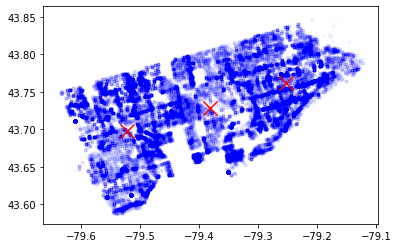

In [33]:
# hist shows bulk is under 10k and mean is 7069. let's see if over that mean accounts for bulk of crime or not

lowpop = df_m2[(df_m2.PopDen <= 7069)]
lowpop.reset_index(inplace=True, drop=True)

centroids, labels = doKMeans(lowpop, 3)

[[-79.40099577  43.66366321]
 [-79.5340874   43.73829463]
 [-79.31320669  43.68860506]]


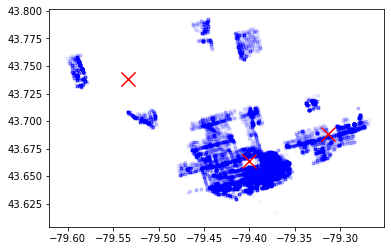

In [34]:
# interesting that the centroids here seem to align with the overall crime centroids - need to figure out optimal # of centroids/clusters

highpop = df_m2[(df_m2.PopDen > 7069)]
highpop.reset_index(inplace=True, drop=True)

centroids, labels = doKMeans(highpop, 3)

## another plotting 

In [35]:
def doKMeans(df):
  #
  # INFO: Plot data with a '.' marker, with 0.3 alpha at the Longitude,
  # and Latitude locations in your dataset. Longitude = x, Latitude = y
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.scatter(df.Long, df.Lat, marker='.', alpha=0.005)

  #
  # : Filter df so that you're only looking at Longitude and Latitude,
  # since the remaining columns aren't really applicable for this purpose.
  #
  sliceK = df[['Long', 'Lat']]


  #
  # : Use K-Means to try and find seven cluster centers in this df.
  #

  model = KMeans(n_clusters=5, n_init=10, init='random')
  model.fit(sliceK)

  #
  # INFO: Print and plot the centroids...
  centroids = model.cluster_centers_

  ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5,
             linewidths=3, s=169)

  print (centroids)

[[-79.40881763  43.7581389 ]
 [-79.25674736  43.75745666]
 [-79.47801631  43.65677682]
 [-79.37605776  43.66545903]
 [-79.54483595  43.72743013]]


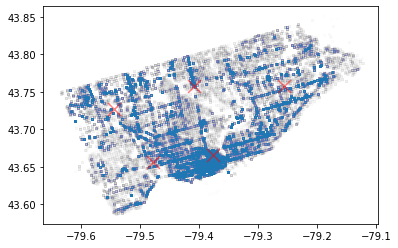

In [36]:
doKMeans(df_m2)

In [37]:
centroid = reverse_geocode([-79.54962227 , 43.73100071])
centroid['address']

{'Match_addr': 'Summerlea Park',
 'LongLabel': 'Summerlea Park, Albion Rd, Etobicoke, Toronto, Ontario, M9W, CAN',
 'ShortLabel': 'Summerlea Park',
 'Addr_type': 'POI',
 'Type': 'Park',
 'PlaceName': 'Summerlea Park',
 'AddNum': '',
 'Address': 'Albion Rd',
 'Block': '',
 'Sector': '',
 'Neighborhood': 'Elms-Old Rexdale',
 'District': 'Etobicoke',
 'City': 'Toronto',
 'MetroArea': 'Greater Toronto Metro Area',
 'Subregion': 'Toronto',
 'Region': 'Ontario',
 'Territory': '',
 'Postal': 'M9W',
 'PostalExt': '',
 'CountryCode': 'CAN'}

### Question: Can we do demographics clustering for future supervised learning?

During exploratory some pairplots exhibited unexpected insights
<break>

In [38]:
keep_cl = ['premisetype', 'occurrenceyear', 'occurrencemonth',
       'occurrenceday', 'occurrencedayofweek', 'occurrencehour','Neighbourhood','Population',
       'PopDen', 'Not_in_workforce', 'Resident_with_Credentials',
       'Resident_without_credentials', 'Average Household Income', 'TTL_RES_UNIT',
       'Soc_Units', 'RGI', 'CRCNumLocations']

In [39]:
df_m3 = df_m[keep_cl]
def PartofDay(a):
    if a in [23,0,1,2]:
        return 'Midnight'
    elif a in [3,4,5,6]:
        return 'Early Morning'
    elif a in [7,8,9,10]:
        return 'Morning'
    elif a in [11,12,13,14]:
        return 'Noon'
    elif a in [15,16,17,18]:
        return 'Evening'
    else:
        return 'Night'
df_m3['PartofDay'] = df_m3.occurrencehour.apply(PartofDay)
obj_cl = list(df_m3.select_dtypes(['object']).columns)
num_cl = [col for col in keep_cl if col not in obj_cl]

<ipython-input-39-a43045639f78>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m3['PartofDay'] = df_m3.occurrencehour.apply(PartofDay)


In [40]:
num_cl

['occurrenceyear',
 'occurrenceday',
 'occurrencehour',
 'Population',
 'PopDen',
 'Not_in_workforce',
 'Resident_with_Credentials',
 'Resident_without_credentials',
 'Average Household Income',
 'TTL_RES_UNIT',
 'Soc_Units',
 'RGI',
 'CRCNumLocations']

In [41]:
def EncodeLabel(col_name):
    df_k = pd.DataFrame()
    Encoders = {}
    for col in col_name:
        Encoders['le' + col] = LabelEncoder()
        df_k[col] = Encoders['le' + col].fit_transform(df_m3[col])
    return df_k, Encoders

In [42]:
df_k, Encoders = EncodeLabel(obj_cl)

In [43]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(df_m3[num_cl])

In [44]:
df_k = pd.concat([df_k, pd.DataFrame(scaled, columns=num_cl)], axis=1)
df_k

,premisetype,occurrencemonth,occurrencedayofweek,Neighbourhood,PartofDay,occurrenceyear,occurrenceday,occurrencehour,Population,PopDen,Not_in_workforce,Resident_with_Credentials,Resident_without_credentials,Average Household Income,TTL_RES_UNIT,Soc_Units,RGI,CRCNumLocations
0,1,7,1,73,2,-1.522366,0.951774,-1.605902,1.445831,-0.365654,1.841337,0.469039,1.817364,-0.672616,-0.826654,-0.005272,-0.172565,1.516404
1,3,11,2,6,1,-1.522366,1.289523,0.474861,0.039897,1.211021,0.490897,0.448652,-1.145463,0.245241,-0.551236,-0.308059,-0.635560,-1.170200
2,1,7,1,124,0,-1.522366,0.951774,-0.912314,0.626973,-1.025862,0.793731,0.057563,1.101473,-0.597766,0.615238,-0.079804,-0.492426,-1.170200
3,0,7,1,30,1,-1.522366,0.951774,0.336144,0.137860,-0.108361,0.472060,0.143961,-0.440100,-0.406791,-0.753749,-1.056875,-0.933514,-0.274665
4,1,8,2,59,2,-1.522366,-1.412469,-1.467184,-0.853098,-0.280521,-1.201501,-0.543863,-0.725855,0.013095,-0.826654,-1.088319,-1.022607,-1.170200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205316,4,2,5,124,0,1.397361,0.951774,-1.189749,0.626973,-1.025862,0.793731,0.057563,1.101473,-0.597766,0.615238,-0.079804,-0.492426,-1.170200
205317,4,2,5,58,1,1.397361,0.951774,0.474861,1.459190,-0.750990,1.295075,1.158480,0.364526,0.117913,1.230878,0.257920,0.627819,0.620870
205318,4,2,5,89,4,1.397361,0.951774,0.891014,-0.521164,6.419613,-0.588586,-0.275844,-0.509282,-0.567900,4.989517,0.798279,1.321583,-0.274665
205319,3,2,5,18,2,1.397361,0.951774,-1.744619,-0.588191,-0.348938,-0.584239,-0.733814,0.504396,-0.573519,0.817751,-0.197425,-0.374121,1.516404


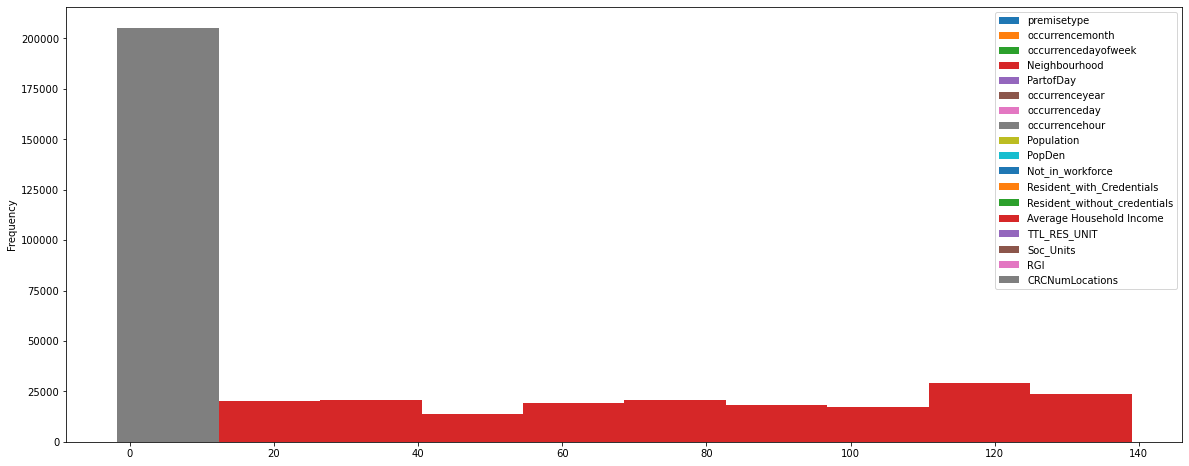

In [45]:
df_k.plot.hist(figsize=(20,8))

In [46]:
def doPCA(data, dimensions=2):
  from sklearn.decomposition import PCA
  model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
  model.fit(data)
  return model


def doKMeans(data, clusters=0):
  #
  # KMeans clustering, passing in the # of clusters parameter
  # and fit it against data. It returns a tuple containing the cluster
  # centers and the labels.
  #

  model = KMeans(n_clusters= clusters, n_init=20, init='random')
  model.fit(data)
  return model.cluster_centers_, model.labels_


In [47]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205321 entries, 0 to 205320
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   premisetype                   205321 non-null  int64  
 1   occurrencemonth               205321 non-null  int64  
 2   occurrencedayofweek           205321 non-null  int64  
 3   Neighbourhood                 205321 non-null  int64  
 4   PartofDay                     205321 non-null  int64  
 5   occurrenceyear                205321 non-null  float64
 6   occurrenceday                 205321 non-null  float64
 7   occurrencehour                205321 non-null  float64
 8   Population                    205321 non-null  float64
 9   PopDen                        205321 non-null  float64
 10  Not_in_workforce              205321 non-null  float64
 11  Resident_with_Credentials     205321 non-null  float64
 12  Resident_without_credentials  205321 non-nul

In [48]:
T=df_k

In [49]:
n_clusters=3

In [50]:
centroids, labels = doKMeans(df_k, n_clusters)

In [51]:
# cluster center vectors

print ("Centroids: ")
for cen in range(0,n_clusters):
  print("   {0}: ".format(cen)) 
  print (centroids[cen])


Centroids: 
   0: 
[ 1.94012756e+00  5.59291343e+00  2.95004753e+00  7.28872620e+01
  2.67765478e+00  5.07622827e-03  2.07628668e-04  2.26421948e-03
 -2.02561748e-01  1.22185722e-01 -2.08355614e-01 -1.77573819e-01
 -9.21652330e-02 -6.10097835e-02  1.07015739e-01  1.69701264e-02
  1.23535037e-01  1.33983906e-01]
   1: 
[ 1.98499131e+00  5.61105573e+00  2.95833452e+00  2.20649617e+01
  2.70293054e+00  2.43945157e-03 -5.50044136e-03  1.78812327e-02
 -1.33226924e-01  1.53900566e-01 -4.84298823e-02 -1.29451554e-01
 -2.97025341e-02  1.04268778e-01 -2.26804251e-01 -1.28655975e-01
 -1.48364581e-01 -1.08912210e-01]
   2: 
[ 1.94774806e+00  5.61086543e+00  2.92665264e+00  1.20442904e+02
  2.65573254e+00 -7.19011186e-03  5.33442156e-03 -2.00850739e-02
  3.22978493e-01 -2.68730673e-01  2.43161261e-01  2.95859408e-01
  1.15882973e-01 -4.78467954e-02  1.28057688e-01  1.13465415e-01
  3.38020245e-02 -1.56030147e-02]


In [52]:
# Do PCA *after* to visualize the results. Project the centroids as well as 
# the samples into the new 2D feature space for visualization purposes.
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

In [53]:
# Add the cluster label back into the dataframe and display it:
df_k['label'] = pd.Series(labels, index=df_k.index)
print (df_k)

        premisetype  occurrencemonth  occurrencedayofweek  Neighbourhood  \
0                 1                7                    1             73   
1                 3               11                    2              6   
2                 1                7                    1            124   
3                 0                7                    1             30   
4                 1                8                    2             59   
...             ...              ...                  ...            ...   
205316            4                2                    5            124   
205317            4                2                    5             58   
205318            4                2                    5             89   
205319            3                2                    5             18   
205320            2                2                    5            102   

        PartofDay  occurrenceyear  occurrenceday  occurrencehour  Population  \
0      

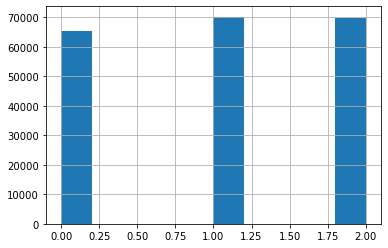

In [54]:
df_k['label'].hist()

In [55]:
centroids

array([[ 1.94012756e+00,  5.59291343e+00,  2.95004753e+00,
         7.28872620e+01,  2.67765478e+00,  5.07622827e-03,
         2.07628668e-04,  2.26421948e-03, -2.02561748e-01,
         1.22185722e-01, -2.08355614e-01, -1.77573819e-01,
        -9.21652330e-02, -6.10097835e-02,  1.07015739e-01,
         1.69701264e-02,  1.23535037e-01,  1.33983906e-01],
       [ 1.98499131e+00,  5.61105573e+00,  2.95833452e+00,
         2.20649617e+01,  2.70293054e+00,  2.43945157e-03,
        -5.50044136e-03,  1.78812327e-02, -1.33226924e-01,
         1.53900566e-01, -4.84298823e-02, -1.29451554e-01,
        -2.97025341e-02,  1.04268778e-01, -2.26804251e-01,
        -1.28655975e-01, -1.48364581e-01, -1.08912210e-01],
       [ 1.94774806e+00,  5.61086543e+00,  2.92665264e+00,
         1.20442904e+02,  2.65573254e+00, -7.19011186e-03,
         5.33442156e-03, -2.00850739e-02,  3.22978493e-01,
        -2.68730673e-01,  2.43161261e-01,  2.95859408e-01,
         1.15882973e-01, -4.78467954e-02,  1.28057688e

In [56]:
# do you do confusion matrix on unsupervised learning?

#print(confusion_matrix(df_k['MCI'],df_k.label))
#print(classification_report(df_k['MCI'],df_k.label))

### Conclusion : now we have 3 clusters 
what do we do with this to visualize?  use for train/test?

### based on elbow method, lets try 5 clusters

In [57]:
T=df_k

In [58]:
n_clusters=5

In [59]:
centroids, labels = doKMeans(df_k, n_clusters)

In [60]:
# cluster center vectors

print ("Centroids: ")
for cen in range(0,n_clusters):
  print("   {0}: ".format(cen)) 
  print (centroids[cen])


Centroids: 
   0: 
[ 1.99020020e+00  5.62911942e+00  2.95517290e+00  3.02802184e+01
  2.69385412e+00 -1.27938652e-03  1.12468430e-03  1.57321356e-02
 -6.26507798e-02  2.77477260e-01 -1.22635389e-01 -7.72889727e-02
  6.62374264e-02 -1.23647497e-01 -1.82265825e-01  8.01766364e-02
  3.87099453e-02 -6.71487521e-02  1.00000000e+00]
   1: 
[ 1.97266177e+00  5.58770453e+00  2.95707360e+00  8.42357417e+00
  2.70530604e+00  1.10067531e-02 -1.28721727e-02  6.99440450e-03
 -2.09196883e-01  5.74728462e-02  7.86306093e-03 -1.19594513e-01
 -3.57119345e-01  3.77452552e-01 -2.46034678e-01 -4.13556163e-01
 -4.50303823e-01 -3.54654739e-01  1.00000000e+00]
   2: 
[ 1.99339924e+00  5.63433601e+00  2.95186569e+00  5.72628549e+01
  2.69799265e+00 -7.87092315e-03 -1.13877650e-02  2.61595839e-02
 -2.94577757e-01 -1.96691933e-01 -1.88306930e-01 -3.11692458e-01
  2.88437256e-02  5.54217092e-02 -1.25879417e-01 -1.13829123e-01
  4.04137395e-02  1.31939746e-01  1.44945446e-01]
   3: 
[ 1.94913538e+00  5.61450566e+

In [61]:
# Do PCA *after* to visualize the results. Project the centroids as well as 
# the samples into the new 2D feature space for visualization purposes.
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

In [62]:
# Add the cluster label back into the dataframe and display it:
df_k['label'] = pd.Series(labels, index=df_k.index)
print (df_k)

        premisetype  occurrencemonth  occurrencedayofweek  Neighbourhood  \
0                 1                7                    1             73   
1                 3               11                    2              6   
2                 1                7                    1            124   
3                 0                7                    1             30   
4                 1                8                    2             59   
...             ...              ...                  ...            ...   
205316            4                2                    5            124   
205317            4                2                    5             58   
205318            4                2                    5             89   
205319            3                2                    5             18   
205320            2                2                    5            102   

        PartofDay  occurrenceyear  occurrenceday  occurrencehour  Population  \
0      

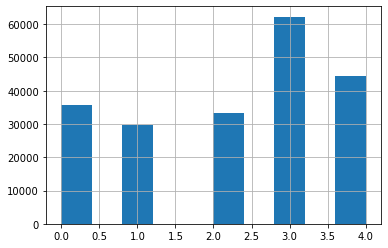

In [63]:
df_k['label'].hist()

In [64]:
# accuracy is WORSE!

#print(confusion_matrix(df_k['MCI'],df_k.label))
#print(classification_report(df_k['MCI'],df_k.label))

In [65]:
# DONT RUN THIS !!!!
# dendogram?  this kills my machine

#plt.figure(figsize = (15, 10))
#row_clusters = linkage(df_k, method="complete", metric="euclidean")
#f = dendrogram(row_clusters, p = 5, truncate_mode="level")

In [66]:
# Calculate Euclidean distance between two observations
def calc_distance(X1, X2):
    return (sum((X1 - X2)**2))**0.5

# Assign cluster clusters based on closest centroid
def assign_clusters(centroids, cluster_array):
    clusters = []
    for i in range(cluster_array.shape[0]):
        distances = []
        for centroid in centroids:
            distances.append(calc_distance(centroid, 
                                           cluster_array[i]))
        cluster = [z for z, val in enumerate(distances) if val==min(distances)]
        clusters.append(cluster[0])
    return clusters

# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

# Calculate variance within each cluster
def calc_centroid_variance(clusters, cluster_array):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, 
                                       current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    return sum_squares

In [67]:
cluster_array = np.array(df_k)

### note this next part takes very long to run for whole dataframe! 

In [68]:
#k = 4
#cluster_vars = []

#centroids = [cluster_array[i+2] for i in range(k)]
#clusters = assign_clusters(centroids, cluster_array)
#initial_clusters = clusters
#print(0, round(np.mean(calc_centroid_variance(clusters, cluster_array))))

#for i in range(20):
#    centroids = calc_centroids(clusters, cluster_array)
#    clusters = assign_clusters(centroids, cluster_array)
#    cluster_var = np.mean(calc_centroid_variance(clusters, 
#                                                 cluster_array))
#    cluster_vars.append(cluster_var)
#    print(i+1, round(cluster_var))

In [69]:
#plt.subplots(figsize=(9,6))
#plt.plot(cluster_vars)
#plt.xlabel('Iterations')
#plt.ylabel('Mean Sum of Squared Deviations');
#plt.savefig('mean_ssd', bpi=150)


### K means on 1 MCI = Theft Over


In [70]:
df_mtheft = df_m[df_m.MCI == "Theft Over"]

In [71]:
keep_cl = ['premisetype', 'occurrenceyear', 'occurrencemonth',
       'occurrenceday', 'occurrencedayofweek', 'occurrencehour','Neighbourhood','Population',
       'PopDen', 'Not_in_workforce', 'Resident_with_Credentials',
       'Resident_without_credentials', 'Average Household Income', 'TTL_RES_UNIT',
       'Soc_Units', 'RGI', 'CRCNumLocations']

In [72]:
df_m3 = df_mtheft[keep_cl]
def PartofDay(a):
    if a in [23,0,1,2]:
        return 'Midnight'
    elif a in [3,4,5,6]:
        return 'Early Morning'
    elif a in [7,8,9,10]:
        return 'Morning'
    elif a in [11,12,13,14]:
        return 'Noon'
    elif a in [15,16,17,18]:
        return 'Evening'
    else:
        return 'Night'
df_m3['PartofDay'] = df_m3.occurrencehour.apply(PartofDay)
obj_cl = list(df_m3.select_dtypes(['object']).columns)
num_cl = [col for col in keep_cl if col not in obj_cl]

<ipython-input-72-2b1eaa7da4ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m3['PartofDay'] = df_m3.occurrencehour.apply(PartofDay)


In [73]:
def EncodeLabel(col_name):
    df_ktheft = pd.DataFrame()
    Encoders = {}
    for col in col_name:
        Encoders['le' + col] = LabelEncoder()
        df_ktheft[col] = Encoders['le' + col].fit_transform(df_m3[col])
    return df_ktheft, Encoders

In [74]:
df_ktheft, Encoders = EncodeLabel(obj_cl)

In [75]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(df_m3[num_cl])

In [76]:
df_ktheft = pd.concat([df_ktheft, pd.DataFrame(scaled, columns=num_cl)], axis=1)
df_ktheft

,premisetype,occurrencemonth,occurrencedayofweek,Neighbourhood,PartofDay,occurrenceyear,occurrenceday,occurrencehour,Population,PopDen,Not_in_workforce,Resident_with_Credentials,Resident_without_credentials,Average Household Income,TTL_RES_UNIT,Soc_Units,RGI,CRCNumLocations
0,2,4,6,125,2,-1.553320,-1.585598,-1.896016,-0.007529,0.096130,0.379557,-0.070433,-0.281503,-0.619331,2.435261,-0.020935,-0.067962,1.704350
1,1,7,6,139,5,-1.553320,1.201139,0.205361,-0.862093,-0.766507,-0.774619,-0.846445,0.062031,-0.446521,-0.848797,-0.385499,-0.496639,-0.218758
2,1,0,5,31,1,-1.553320,0.755261,0.655656,-0.102224,-0.467372,0.004863,-0.354271,0.457419,-0.650063,-0.806368,-0.608485,-0.352715,-0.218758
3,1,6,0,113,5,-1.553320,1.312608,0.205361,-0.098648,-0.634499,-0.183236,-0.101243,-0.300949,0.316221,1.298145,-1.008443,-0.943887,0.742796
4,1,6,5,105,1,-1.553320,0.197913,0.505558,1.499095,-0.976695,1.831682,0.543177,1.648446,-0.415878,-0.831826,-0.768940,-0.719489,1.704350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,4,2,5,122,1,1.371547,0.197913,0.805755,2.945744,0.379205,1.049190,3.608064,-0.579665,0.508596,-0.000204,1.958801,1.064860,0.742796
6664,4,2,1,122,5,1.371547,0.866730,-0.094836,2.945744,0.379205,1.049190,3.608064,-0.579665,0.508596,-0.000204,1.958801,1.064860,0.742796
6665,1,7,5,24,5,1.371547,0.420852,0.205361,0.045369,-0.558083,0.043988,-0.234867,0.463901,-0.514865,-0.042633,-0.662756,-0.744250,1.704350
6666,1,1,5,124,1,1.371547,-1.028251,0.355459,0.516831,-1.001932,0.781337,-0.061291,1.280605,-0.647711,0.653214,-0.039812,-0.431641,-1.180312


In [77]:
df_ktheft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   premisetype                   6668 non-null   int64  
 1   occurrencemonth               6668 non-null   int64  
 2   occurrencedayofweek           6668 non-null   int64  
 3   Neighbourhood                 6668 non-null   int64  
 4   PartofDay                     6668 non-null   int64  
 5   occurrenceyear                6668 non-null   float64
 6   occurrenceday                 6668 non-null   float64
 7   occurrencehour                6668 non-null   float64
 8   Population                    6668 non-null   float64
 9   PopDen                        6668 non-null   float64
 10  Not_in_workforce              6668 non-null   float64
 11  Resident_with_Credentials     6668 non-null   float64
 12  Resident_without_credentials  6668 non-null   float64
 13  Ave

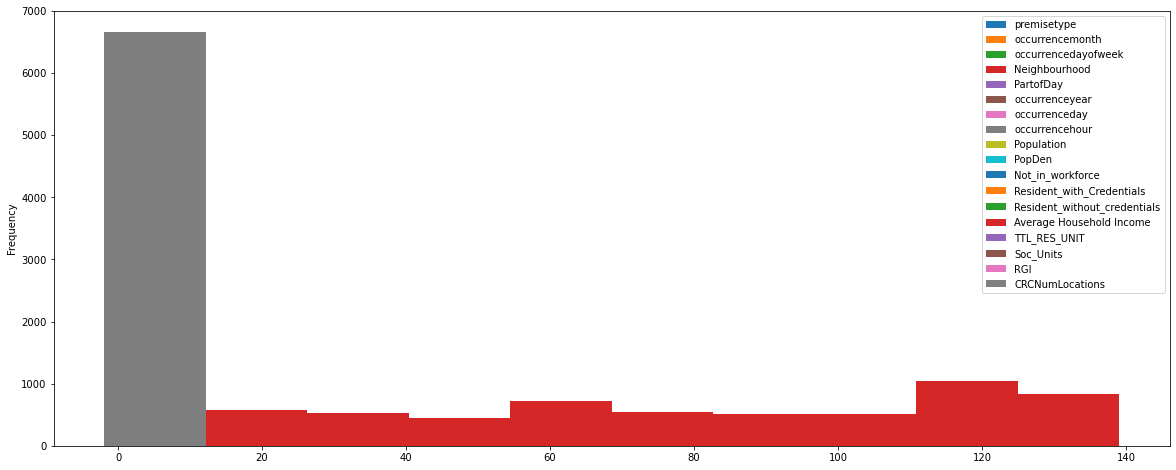

In [78]:
df_ktheft.plot.hist(figsize=(20,8))

In [79]:
def doPCA(data, dimensions=2):
  from sklearn.decomposition import PCA
  model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
  model.fit(data)
  return model


def doKMeans(data, clusters=0):
  #
  # KMeans clustering, passing in the # of clusters parameter
  # and fit it against data. It returns a tuple containing the cluster
  # centers and the labels.
  #

  model = KMeans(n_clusters= clusters, max_iter=300,n_init=10, init='random')
  model.fit(data)
  return model.cluster_centers_, model.labels_


In [80]:
n_clusters=5
centroids, labels = doKMeans(df_ktheft, n_clusters)

In [81]:
# cluster center vectors

print ("Centroids: ")
for cen in range(0,n_clusters):
  print("   {0}: ".format(cen)) 
  print (centroids[cen])


Centroids: 
   0: 
[ 1.80858676  5.74686941  2.94007156  6.92844365  2.91234347  0.02160819
 -0.02831571 -0.02086057 -0.18339723  0.18417354  0.07015777 -0.09897252
 -0.41127081  0.40317563 -0.36443862 -0.36770576 -0.43709491 -0.40969256]
   1: 
[ 2.03750000e+00  5.63500000e+00  2.93916667e+00  5.95575000e+01
  2.81000000e+00  2.80578963e-02 -2.46538977e-02  2.12403790e-02
 -2.20797559e-01 -2.39017156e-01 -1.73034359e-01 -2.37037328e-01
 -5.87125178e-02 -5.27002589e-02  4.98139142e-02 -1.00603310e-01
  8.20236782e-02  2.14742734e-01]
   2: 
[ 1.90874882e+00  5.54092192e+00  2.98494826e+00  3.06142992e+01
  2.92097836e+00 -2.62259360e-02  1.71462471e-03  1.21958797e-02
 -1.80112601e-01  3.78164673e-01 -2.00439500e-01 -2.00288765e-01
  1.12654868e-01 -3.99834706e-02 -2.74276285e-01  1.92263639e-01
  2.17174237e-01  5.98485661e-02]
   3: 
[ 1.99338843e+00  5.54628099e+00  2.95041322e+00  8.91099174e+01
  2.92809917e+00  5.70487206e-02  6.57290555e-03  1.51950936e-02
 -2.51883678e-01  2.68

In [82]:
# Add the cluster label back into the dataframe and display it:
df_ktheft['label'] = pd.Series(labels, index=df_ktheft.index)
print (df_ktheft)

      premisetype  occurrencemonth  occurrencedayofweek  Neighbourhood  \
0               2                4                    6            125   
1               1                7                    6            139   
2               1                0                    5             31   
3               1                6                    0            113   
4               1                6                    5            105   
...           ...              ...                  ...            ...   
6663            4                2                    5            122   
6664            4                2                    1            122   
6665            1                7                    5             24   
6666            1                1                    5            124   
6667            1                1                    4             86   

      PartofDay  occurrenceyear  occurrenceday  occurrencehour  Population  \
0             2       -1.553320  

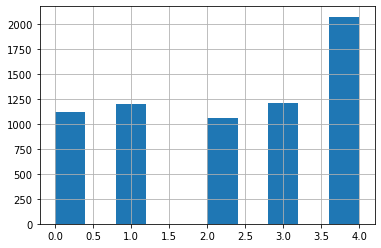

In [83]:
df_ktheft['label'].hist()

In [84]:
# do you do confusion matrix on unsupervised learning?

#print(confusion_matrix(df_ktheft['MCI'],df_ktheft.label))
#print(classification_report(df_ktheft['MCI'],df_ktheft.label))

In [85]:
centroids

array([[ 1.80858676e+00,  5.74686941e+00,  2.94007156e+00,
         6.92844365e+00,  2.91234347e+00,  2.16081910e-02,
        -2.83157061e-02, -2.08605658e-02, -1.83397232e-01,
         1.84173544e-01,  7.01577726e-02, -9.89725202e-02,
        -4.11270812e-01,  4.03175629e-01, -3.64438623e-01,
        -3.67705762e-01, -4.37094910e-01, -4.09692556e-01],
       [ 2.03750000e+00,  5.63500000e+00,  2.93916667e+00,
         5.95575000e+01,  2.81000000e+00,  2.80578963e-02,
        -2.46538977e-02,  2.12403790e-02, -2.20797559e-01,
        -2.39017156e-01, -1.73034359e-01, -2.37037328e-01,
        -5.87125178e-02, -5.27002589e-02,  4.98139142e-02,
        -1.00603310e-01,  8.20236782e-02,  2.14742734e-01],
       [ 1.90874882e+00,  5.54092192e+00,  2.98494826e+00,
         3.06142992e+01,  2.92097836e+00, -2.62259360e-02,
         1.71462471e-03,  1.21958797e-02, -1.80112601e-01,
         3.78164673e-01, -2.00439500e-01, -2.00288765e-01,
         1.12654868e-01, -3.99834706e-02, -2.74276285e

In [86]:
centroids[0]-centroids[1]

array([-2.28913238e-01,  1.11869410e-01,  9.04889684e-04, -5.26290564e+01,
        1.02343470e-01, -6.44970534e-03, -3.66180838e-03, -4.21009448e-02,
        3.74003265e-02,  4.23190700e-01,  2.43192131e-01,  1.38064808e-01,
       -3.52558295e-01,  4.55875888e-01, -4.14252538e-01, -2.67102453e-01,
       -5.19118588e-01, -6.24435291e-01])

In [87]:
abs(centroids[0]-centroids[1])

array([2.28913238e-01, 1.11869410e-01, 9.04889684e-04, 5.26290564e+01,
       1.02343470e-01, 6.44970534e-03, 3.66180838e-03, 4.21009448e-02,
       3.74003265e-02, 4.23190700e-01, 2.43192131e-01, 1.38064808e-01,
       3.52558295e-01, 4.55875888e-01, 4.14252538e-01, 2.67102453e-01,
       5.19118588e-01, 6.24435291e-01])

In [88]:
# lets take columns 3, 18, 14, 17, 12, 10
# those are Neighbourhood, label, TTL_RES_UNIT, CRCNumLocations, Resident_without_credentials, Not_in_workforce..
numpy.argsort(-1*abs(centroids[0]-centroids[1]))

array([ 3, 17, 16, 13,  9, 14, 12, 15, 10,  0, 11,  1,  4,  7,  8,  5,  6,
        2])

In [89]:
numpy.argsort(-1*abs(centroids[1]-centroids[2]))

array([ 3,  9, 14, 15, 12, 17, 16,  0,  4,  1,  5,  2,  8, 11, 10,  6, 13,
        7])

In [90]:
numpy.argsort(-1*abs(centroids[2]-centroids[3]))

array([ 3, 14, 15, 12, 16, 10,  9, 13,  0,  5,  8, 17,  2, 11,  4,  1,  6,
        7])

In [91]:
numpy.argsort(-1*abs(centroids[3]-centroids[4]))

array([ 3,  8, 10, 11,  9, 12, 13, 15,  1,  4,  5, 17,  0, 16,  7, 14,  6,
        2])

In [92]:
numpy.argsort(-1*abs(centroids[1]-centroids[4]))

array([ 3,  8, 11, 10, 12, 15, 17, 14, 13,  0,  1,  5,  9, 16,  6,  7,  2,
        4])

In [93]:
numpy.argsort(-1*abs(centroids[2]-centroids[4]))

array([ 3,  9,  8, 11, 10, 14,  1, 16, 13, 12,  4, 17,  2,  7,  6,  5, 15,
        0])

In [94]:
numpy.argsort(-1*abs(centroids[0]-centroids[4]))

array([ 3, 12,  8, 13, 14, 15, 11,  9, 16, 17, 10,  0,  4,  5,  6,  1,  2,
        7])

In [95]:
centroids[0]

array([ 1.80858676,  5.74686941,  2.94007156,  6.92844365,  2.91234347,
        0.02160819, -0.02831571, -0.02086057, -0.18339723,  0.18417354,
        0.07015777, -0.09897252, -0.41127081,  0.40317563, -0.36443862,
       -0.36770576, -0.43709491, -0.40969256])

In [96]:
centroids[1]

array([ 2.03750000e+00,  5.63500000e+00,  2.93916667e+00,  5.95575000e+01,
        2.81000000e+00,  2.80578963e-02, -2.46538977e-02,  2.12403790e-02,
       -2.20797559e-01, -2.39017156e-01, -1.73034359e-01, -2.37037328e-01,
       -5.87125178e-02, -5.27002589e-02,  4.98139142e-02, -1.00603310e-01,
        8.20236782e-02,  2.14742734e-01])

In [97]:
centroids[:,0]

array([1.80858676, 2.0375    , 1.90874882, 1.99338843, 1.91815118])

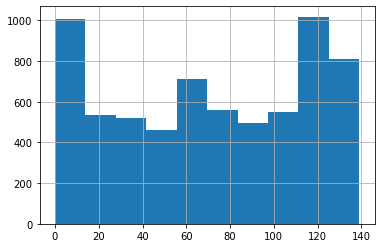

In [100]:
df_ktheft['Neighbourhood'].hist()

In [101]:
Counter(df_ktheft['Neighbourhood']).most_common(10)

[(122, 334),
 (124, 310),
 (6, 306),
 (58, 241),
 (138, 217),
 (23, 199),
 (3, 170),
 (62, 159),
 (139, 135),
 (110, 125)]

### lets do K=3

In [102]:
def doPCA(data, dimensions=2):
  from sklearn.decomposition import PCA
  model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
  model.fit(data)
  return model


def doKMeans(data, clusters=0):
  #
  # KMeans clustering, passing in the # of clusters parameter
  # and fit it against data. It returns a tuple containing the cluster
  # centers and the labels.
  #

  model = KMeans(n_clusters= clusters, max_iter=300,n_init=10, init='random')
  model.fit(data)
  return model.cluster_centers_, model.labels_


In [103]:
n_clusters=3
centroids, labels = doKMeans(df_ktheft, n_clusters)

In [104]:
# cluster center vectors

print ("Centroids: ")
for cen in range(0,n_clusters):
  print("   {0}: ".format(cen)) 
  print (centroids[cen])


Centroids: 
   0: 
[ 1.85782671e+00  5.67065582e+00  2.96792724e+00  1.73298229e+01
  2.91383437e+00  2.22181002e-03 -1.45135028e-02  2.52346561e-03
 -1.76081229e-01  2.99208383e-01 -6.68039705e-02 -1.26639316e-01
 -2.18807914e-01  1.50386636e-01 -3.12538156e-01 -9.71533895e-02
 -1.34476969e-01 -2.32566679e-01  9.29631403e-01]
   1: 
[ 1.94184628e+00  5.71980480e+00  2.94713298e+00  1.21161448e+02
  2.83204555e+00 -2.55856676e-02  2.70601054e-02 -1.07762709e-03
  3.55663711e-01 -3.08098969e-01  2.71846410e-01  2.97024208e-01
  2.15864328e-01 -9.95656517e-02  1.07408017e-01  9.97562307e-02
 -1.75602915e-02  6.04408198e-02  3.84505897e+00]
   2: 
[ 1.99811321e+00  5.56556604e+00  2.93726415e+00  6.82561321e+01
  2.86415094e+00  2.74876393e-02 -1.70858924e-02 -1.23662012e-03
 -2.39029895e-01  6.25325715e-02 -2.49489070e-01 -2.19732545e-01
 -3.47738917e-02 -3.27008228e-02  1.83384855e-01 -1.99750664e-02
  1.52878842e-01  1.59060291e-01  1.82452830e+00]


In [105]:
# Add the cluster label back into the dataframe and display it:
df_ktheft['label'] = pd.Series(labels, index=df_ktheft.index)
print (df_ktheft)

      premisetype  occurrencemonth  occurrencedayofweek  Neighbourhood  \
0               2                4                    6            125   
1               1                7                    6            139   
2               1                0                    5             31   
3               1                6                    0            113   
4               1                6                    5            105   
...           ...              ...                  ...            ...   
6663            4                2                    5            122   
6664            4                2                    1            122   
6665            1                7                    5             24   
6666            1                1                    5            124   
6667            1                1                    4             86   

      PartofDay  occurrenceyear  occurrenceday  occurrencehour  Population  \
0             2       -1.553320  

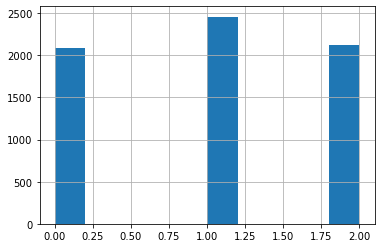

In [106]:
df_ktheft['label'].hist()

In [107]:
centroids

array([[ 1.85782671e+00,  5.67065582e+00,  2.96792724e+00,
         1.73298229e+01,  2.91383437e+00,  2.22181002e-03,
        -1.45135028e-02,  2.52346561e-03, -1.76081229e-01,
         2.99208383e-01, -6.68039705e-02, -1.26639316e-01,
        -2.18807914e-01,  1.50386636e-01, -3.12538156e-01,
        -9.71533895e-02, -1.34476969e-01, -2.32566679e-01,
         9.29631403e-01],
       [ 1.94184628e+00,  5.71980480e+00,  2.94713298e+00,
         1.21161448e+02,  2.83204555e+00, -2.55856676e-02,
         2.70601054e-02, -1.07762709e-03,  3.55663711e-01,
        -3.08098969e-01,  2.71846410e-01,  2.97024208e-01,
         2.15864328e-01, -9.95656517e-02,  1.07408017e-01,
         9.97562307e-02, -1.75602915e-02,  6.04408198e-02,
         3.84505897e+00],
       [ 1.99811321e+00,  5.56556604e+00,  2.93726415e+00,
         6.82561321e+01,  2.86415094e+00,  2.74876393e-02,
        -1.70858924e-02, -1.23662012e-03, -2.39029895e-01,
         6.25325715e-02, -2.49489070e-01, -2.19732545e-01,
    

In [108]:
centroids[0]-centroids[1]

array([-8.40195676e-02, -4.91489825e-02,  2.07942570e-02, -1.03831625e+02,
        8.17888235e-02,  2.78074776e-02, -4.15736082e-02,  3.60109271e-03,
       -5.31744940e-01,  6.07307352e-01, -3.38650380e-01, -4.23663524e-01,
       -4.34672242e-01,  2.49952287e-01, -4.19946173e-01, -1.96909620e-01,
       -1.16916677e-01, -2.93007499e-01, -2.91542756e+00])

In [109]:
centroids[1]-centroids[2]

array([-5.62669286e-02,  1.54238761e-01,  9.86882994e-03,  5.29053157e+01,
       -3.21053964e-02, -5.30733069e-02,  4.41459978e-02,  1.58993024e-04,
        5.94693605e-01, -3.70631540e-01,  5.21335480e-01,  5.16756753e-01,
        2.50638220e-01, -6.68648289e-02, -7.59768373e-02,  1.19731297e-01,
       -1.70439133e-01, -9.86194714e-02,  2.02053067e+00])

In [110]:
centroids[0]-centroids[2]

array([-1.40286496e-01,  1.05089778e-01,  3.06630870e-02, -5.09263092e+01,
        4.96834271e-02, -2.52658293e-02,  2.57238962e-03,  3.76008573e-03,
        6.29486652e-02,  2.36675812e-01,  1.82685099e-01,  9.30932290e-02,
       -1.84034022e-01,  1.83087459e-01, -4.95923010e-01, -7.71783231e-02,
       -2.87355810e-01, -3.91626970e-01, -8.94896899e-01])

In [111]:
abs(centroids[0]-centroids[1])

array([8.40195676e-02, 4.91489825e-02, 2.07942570e-02, 1.03831625e+02,
       8.17888235e-02, 2.78074776e-02, 4.15736082e-02, 3.60109271e-03,
       5.31744940e-01, 6.07307352e-01, 3.38650380e-01, 4.23663524e-01,
       4.34672242e-01, 2.49952287e-01, 4.19946173e-01, 1.96909620e-01,
       1.16916677e-01, 2.93007499e-01, 2.91542756e+00])

In [112]:
# lets take columns 3, 18, 14, 17, 12, 10
# those are Neighbourhood, label, TTL_RES_UNIT, CRCNumLocations, Resident_without_credentials, Not_in_workforce..
numpy.argsort(-1*abs(centroids[0]-centroids[1]))

array([ 3, 18,  9,  8, 12, 11, 14, 10, 17, 13, 15, 16,  0,  4,  1,  6,  5,
        2,  7])

In [113]:
numpy.argsort(-1*abs(centroids[1]-centroids[2]))

array([ 3, 18,  8, 10, 11,  9, 12, 16,  1, 15, 17, 14, 13,  0,  5,  6,  4,
        2,  7])

In [114]:
numpy.argsort(-1*abs(centroids[0]-centroids[2]))

array([ 3, 18, 14, 17, 16,  9, 12, 13, 10,  0,  1, 11, 15,  8,  4,  2,  5,
        7,  6])

In [115]:
centroids[:,0]

array([1.85782671, 1.94184628, 1.99811321])

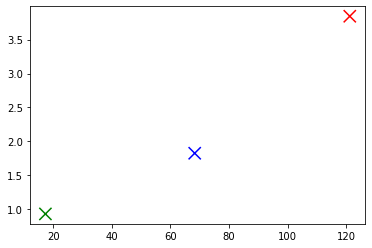

In [116]:
centroids_x = centroids[:,3]
centroids_y = centroids[:,18]
plt.scatter(centroids_x,centroids_y,marker = "x", s=150,linewidths = 5, zorder = 10, c=['green', 'red','blue'])


In [117]:
centroids[:,3]

array([ 17.32982288, 121.16144774,  68.25613208])

In [118]:
centroids[:,17]

array([-0.23256668,  0.06044082,  0.15906029])

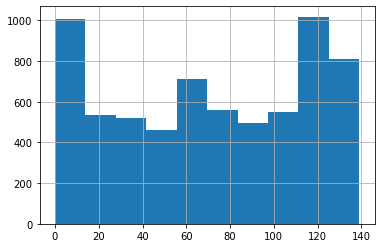

In [119]:
df_ktheft['Neighbourhood'].hist()

In [120]:
Counter(df_ktheft['Neighbourhood']).most_common(10)

[(122, 334),
 (124, 310),
 (6, 306),
 (58, 241),
 (138, 217),
 (23, 199),
 (3, 170),
 (62, 159),
 (139, 135),
 (110, 125)]

### Hierarchical clustering - dendogram

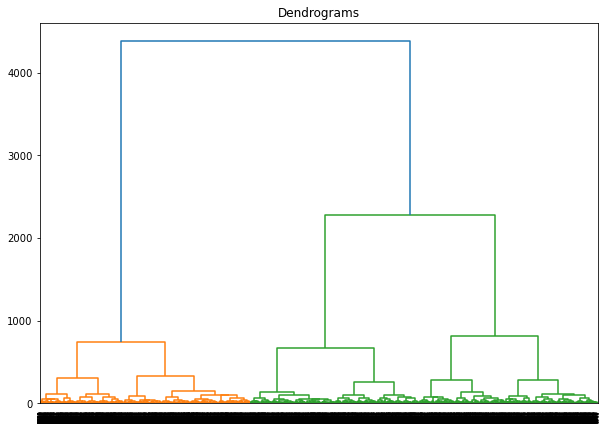

In [121]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_ktheft, method='ward'))

In [122]:
# vertical line with maximum ditance is blue line and hence threshold of around 2500
# we have 2 clusters at this lines cuts the dendogram at two points

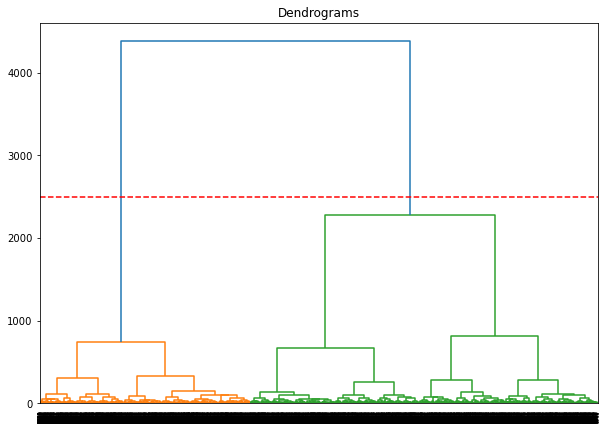

In [123]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_ktheft, method='ward'))
plt.axhline(y=2500, color='r', linestyle='--')

In [124]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_ktheft)

array([1, 1, 0, ..., 0, 1, 0])

<Figure size 1080x720 with 0 Axes>

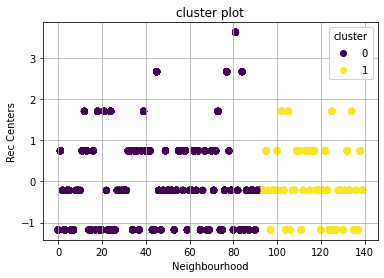

In [125]:
plt.figure(figsize=(15, 10))  

fig, ax = plt.subplots()
scatter = ax.scatter(df_ktheft['Neighbourhood'], df_ktheft['CRCNumLocations'], 
           c=cluster.labels_)

legend1=ax.legend(*scatter.legend_elements(),loc="upper right", title="cluster")
ax.add_artist(legend1)
ax.grid(True)
plt.title("cluster plot")
plt.xlabel("Neighbourhood")
plt.ylabel("Rec Centers")
plt.show()

In [126]:
df_ktheft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   premisetype                   6668 non-null   int64  
 1   occurrencemonth               6668 non-null   int64  
 2   occurrencedayofweek           6668 non-null   int64  
 3   Neighbourhood                 6668 non-null   int64  
 4   PartofDay                     6668 non-null   int64  
 5   occurrenceyear                6668 non-null   float64
 6   occurrenceday                 6668 non-null   float64
 7   occurrencehour                6668 non-null   float64
 8   Population                    6668 non-null   float64
 9   PopDen                        6668 non-null   float64
 10  Not_in_workforce              6668 non-null   float64
 11  Resident_with_Credentials     6668 non-null   float64
 12  Resident_without_credentials  6668 non-null   float64
 13  Ave

### note this next part normally takes very long to run for whole dataframe but for 1 MCI its much better

### elbow method


In [127]:
# Calculate Euclidean distance between two observations
def calc_distance(X1, X2):
    return (sum((X1 - X2)**2))**0.5

# Assign cluster clusters based on closest centroid
def assign_clusters(centroids, cluster_array):
    clusters = []
    for i in range(cluster_array.shape[0]):
        distances = []
        for centroid in centroids:
            distances.append(calc_distance(centroid, 
                                           cluster_array[i]))
        cluster = [z for z, val in enumerate(distances) if val==min(distances)]
        clusters.append(cluster[0])
    return clusters

# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

# Calculate variance within each cluster
def calc_centroid_variance(clusters, cluster_array):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, 
                                       current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    return sum_squares

In [128]:
cluster_array = np.array(df_ktheft)

In [129]:
k = 3
cluster_vars = []

centroids = [cluster_array[i+2] for i in range(k)]
clusters = assign_clusters(centroids, cluster_array)
initial_clusters = clusters
print(0, round(np.mean(calc_centroid_variance(clusters, cluster_array))))

for i in range(20):
    centroids = calc_centroids(clusters, cluster_array)
    clusters = assign_clusters(centroids, cluster_array)
    cluster_var = np.mean(calc_centroid_variance(clusters, 
                                                 cluster_array))
    cluster_vars.append(cluster_var)
    print(i+1, round(cluster_var))

0 682930.0
1 589767.0
2 502499.0
3 453129.0
4 442710.0
5 440382.0
6 439334.0
7 439334.0
8 439334.0
9 439334.0
10 439334.0
11 439334.0
12 439334.0
13 439334.0
14 439334.0
15 439334.0
16 439334.0
17 439334.0
18 439334.0
19 439334.0
20 439334.0


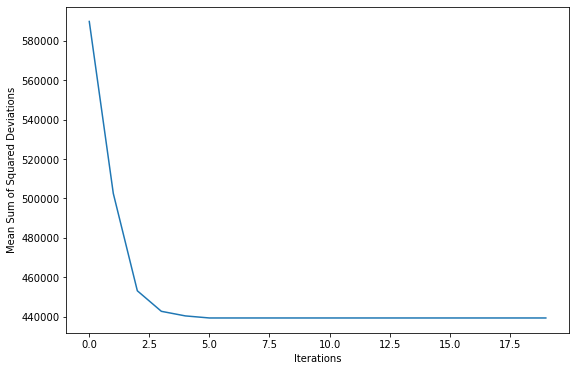

In [130]:
plt.subplots(figsize=(9,6))
plt.plot(cluster_vars)
plt.xlabel('Iterations')
plt.ylabel('Mean Sum of Squared Deviations');
plt.savefig('mean_ssd', bpi=150)


In [131]:
# Applying K-means to the dataset
X=df_ktheft
kmeans = KMeans(n_clusters =  5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X) 

In [132]:
y_kmeans

array([2, 2, 4, ..., 4, 2, 1], dtype=int32)

In [133]:
df_ktheft

,premisetype,occurrencemonth,occurrencedayofweek,Neighbourhood,PartofDay,occurrenceyear,occurrenceday,occurrencehour,Population,PopDen,Not_in_workforce,Resident_with_Credentials,Resident_without_credentials,Average Household Income,TTL_RES_UNIT,Soc_Units,RGI,CRCNumLocations,label
0,2,4,6,125,2,-1.553320,-1.585598,-1.896016,-0.007529,0.096130,0.379557,-0.070433,-0.281503,-0.619331,2.435261,-0.020935,-0.067962,1.704350,1
1,1,7,6,139,5,-1.553320,1.201139,0.205361,-0.862093,-0.766507,-0.774619,-0.846445,0.062031,-0.446521,-0.848797,-0.385499,-0.496639,-0.218758,1
2,1,0,5,31,1,-1.553320,0.755261,0.655656,-0.102224,-0.467372,0.004863,-0.354271,0.457419,-0.650063,-0.806368,-0.608485,-0.352715,-0.218758,0
3,1,6,0,113,5,-1.553320,1.312608,0.205361,-0.098648,-0.634499,-0.183236,-0.101243,-0.300949,0.316221,1.298145,-1.008443,-0.943887,0.742796,1
4,1,6,5,105,1,-1.553320,0.197913,0.505558,1.499095,-0.976695,1.831682,0.543177,1.648446,-0.415878,-0.831826,-0.768940,-0.719489,1.704350,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,4,2,5,122,1,1.371547,0.197913,0.805755,2.945744,0.379205,1.049190,3.608064,-0.579665,0.508596,-0.000204,1.958801,1.064860,0.742796,1
6664,4,2,1,122,5,1.371547,0.866730,-0.094836,2.945744,0.379205,1.049190,3.608064,-0.579665,0.508596,-0.000204,1.958801,1.064860,0.742796,1
6665,1,7,5,24,5,1.371547,0.420852,0.205361,0.045369,-0.558083,0.043988,-0.234867,0.463901,-0.514865,-0.042633,-0.662756,-0.744250,1.704350,0
6666,1,1,5,124,1,1.371547,-1.028251,0.355459,0.516831,-1.001932,0.781337,-0.061291,1.280605,-0.647711,0.653214,-0.039812,-0.431641,-1.180312,1


### silhouette coeffeicient
don't know how to interpret

In [134]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
}

silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_ktheft)
    score = silhouette_score(df_ktheft, kmeans.labels_)
    silhouette_coefficients.append(score)

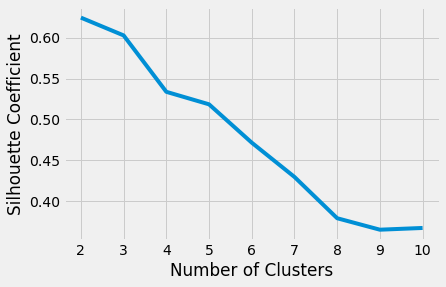

In [135]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()